In [1]:
import random
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import cbor2

assert torch.cuda.is_available()
random.seed(42)
torch.manual_seed(42)
summary = SummaryWriter("runs/attention-v4")

In [2]:
# CONSTANTS
CONTEXT_LEN = 1024
BATCH_SIZE = 32
EMBED_LEN = 32
ADDED_PARAM_LEN = 3 # duration, delay, velocity
PARAM_LEN = 1 + ADDED_PARAM_LEN
DROPOUT_RATE = 0.0001
TOKEN_LEN = 128

In [3]:
track_paths = glob.glob('moonlight.tokens')
#display(track_paths)
tracks = []
for path in track_paths:
    with open(path, 'rb') as f:
        track_data = cbor2.load(f)
        if len(track_data) < 100:
            print("too short:", path)
        tracks.append(track_data)

In [4]:
print(tracks[0][0:5])
print(len(tracks))

[[2, 0.0, 0.0, 0.0], [37, 4.0, 0.0, 0.29133858267716534], [49, 4.0, 0.0, 0.2283464566929134], [56, 0.010416666666666666, 0.0, 0.36220472440944884], [61, 0.0, 0.3333333333333333, 0.23622047244094488]]
1


In [5]:
data = torch.tensor([event for track in tracks for event in track])
split_n = int(0.9 * len(data))
train_data = data[:split_n]
eval_data = data[split_n:]

In [6]:
def get_batch(split):
    data = train_data if split == 'train' else eval_data
    ix = torch.randint(len(data) - CONTEXT_LEN, (BATCH_SIZE,))
    x = torch.stack([data[i:i+CONTEXT_LEN] for i in ix])
    y = torch.stack([data[i+1:i+CONTEXT_LEN+1] for i in ix])
    return x.cuda(), y.cuda()

In [7]:
get_batch('train')[0].shape

torch.Size([32, 1024, 4])

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, head_size, n_embed=(EMBED_LEN + ADDED_PARAM_LEN)):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.register_buffer('tril', torch.tril(torch.ones(CONTEXT_LEN, CONTEXT_LEN)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        w = q @ k.transpose(-2, -1) * C**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        v = self.value(x)
        out = w @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embed=(EMBED_LEN + ADDED_PARAM_LEN)):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size, n_embed, bias=False)
        self.dropout = nn.Dropout(DROPOUT_RATE)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection(out)
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(DROPOUT_RATE),
        )
    def forward(self, x):
        return self.net(x)

class SABlock(nn.Module):
    def __init__(self, n_embed, n_head, n_added=ADDED_PARAM_LEN):
        super().__init__()
        head_size = (n_embed + n_added) // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed + n_added)
        self.ln1 = nn.LayerNorm(n_embed + n_added)
        self.ln2 = nn.LayerNorm(n_embed + n_added)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
@dataclass
class ModelConfig:
    context_len: int = 1024
    

In [9]:
class Model(nn.Module):
    def __init__(self, n_hidden_neurons, n_sa_heads=4):
        super().__init__()
        self.token_embedding_table = nn.Embedding(TOKEN_LEN, EMBED_LEN)
        self.position_embedding_table = nn.Embedding(CONTEXT_LEN, EMBED_LEN)
        # self.sa_head = SelfAttention(EMBED_LEN)
        self.blocks = nn.Sequential(
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
        )
        self.lm_head = nn.Linear(EMBED_LEN + ADDED_PARAM_LEN, TOKEN_LEN + ADDED_PARAM_LEN, bias=False)
        
    def forward(self, x, targets=None):
        B, T, C = x.shape
        tokens = x[:,:,0].long()
        added = x[:,:,1:].view(-1, CONTEXT_LEN, ADDED_PARAM_LEN)
        tok_emb = self.token_embedding_table(tokens)
        pos_emb = self.position_embedding_table(torch.arange(T, device='cuda'))
        x = tok_emb + pos_emb
        x = torch.cat((x, added), dim=2)
        x = self.blocks(x)
        logits = self.lm_head(x)
        if targets is None:
            return logits, None, None, None
        B, T, C = logits.shape
        classes = targets[:, :, 0].long()
        added_params = targets[:, :, 1:]
        label_loss = F.cross_entropy(logits.view(B*T, C), classes.view(B*T))
        sq_err = ((added_params[:, :, -ADDED_PARAM_LEN:] - logits[:, :, -ADDED_PARAM_LEN:]) ** 2)
        added_param_loss = sq_err.mean(dim=1).mean(dim=0).sum()
        loss = label_loss + added_param_loss
        return logits, loss, label_loss, added_param_loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens):
        model.eval()
        out = []
        for _ in range(max_new_tokens):
            idx = idx[:, -CONTEXT_LEN:] # truncate context
            logits, loss, _, _ = self(idx)
            probs = F.softmax(logits[:, -1, :TOKEN_LEN], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # B, 1
            token = next_token.int().item()
            added_params = logits[:,-1,-ADDED_PARAM_LEN:].view(1, ADDED_PARAM_LEN)
            next_idx = torch.cat((next_token, added_params), dim=-1) # B, 3
            out.append([token] + added_params.tolist()[0])
            idx = torch.cat((idx, next_idx.view(1, -1, PARAM_LEN)), dim=1)
            if next_token.item() == 3:
                break
        return out


In [10]:
model = Model(BATCH_SIZE).cuda()
summary.add_graph(model, get_batch('train'))
global_training_steps = 0

In [11]:
lossi = []
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)
scaler = torch.cuda.amp.GradScaler()
max_steps = 100_000

for i in range(max_steps+1):
    global_training_steps += 1
    Xb, Yb = get_batch('train')
    optimizer.zero_grad(set_to_none=True)
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        logits, loss, label_loss, added_param_loss = model(Xb, Yb)
    if i % 10 == 0:
        summary.add_scalar('loss', loss.item(), global_training_steps)
        summary.add_scalar('label_loss', label_loss.item(), global_training_steps)
        summary.add_scalar('added_param_loss', added_param_loss.item(), global_training_steps)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # loss.backward()
    # optimizer.step()
    # track
    scheduler.step()
    if i % 100 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}, lr={scheduler.get_last_lr()}")
    lossi.append(loss.log10().item())

/home/bob/src/midi-tokenizer/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


      0/ 100000: 10.4021, lr=[0.01]
    100/ 100000: 3.3648, lr=[0.01]
    200/ 100000: 2.3629, lr=[0.01]
    300/ 100000: 1.4017, lr=[0.01]
    400/ 100000: 0.7763, lr=[0.01]
    500/ 100000: 0.5198, lr=[0.002]
    600/ 100000: 0.3261, lr=[0.002]
    700/ 100000: 0.3094, lr=[0.002]
    800/ 100000: 0.2733, lr=[0.002]
    900/ 100000: 0.2114, lr=[0.002]
   1000/ 100000: 0.1722, lr=[0.0004]
   1100/ 100000: 0.1775, lr=[0.0004]
   1200/ 100000: 0.1490, lr=[0.0004]
   1300/ 100000: 0.1550, lr=[0.0004]
   1400/ 100000: 0.1346, lr=[0.0004]
   1500/ 100000: 0.1415, lr=[8e-05]
   1600/ 100000: 0.1404, lr=[8e-05]
   1700/ 100000: 0.1178, lr=[8e-05]
   1800/ 100000: 0.1189, lr=[8e-05]
   1900/ 100000: 0.1122, lr=[8e-05]
   2000/ 100000: 0.1431, lr=[1.6000000000000003e-05]
   2100/ 100000: 0.1174, lr=[1.6000000000000003e-05]
   2200/ 100000: 0.1269, lr=[1.6000000000000003e-05]
   2300/ 100000: 0.1365, lr=[1.6000000000000003e-05]


KeyboardInterrupt: 

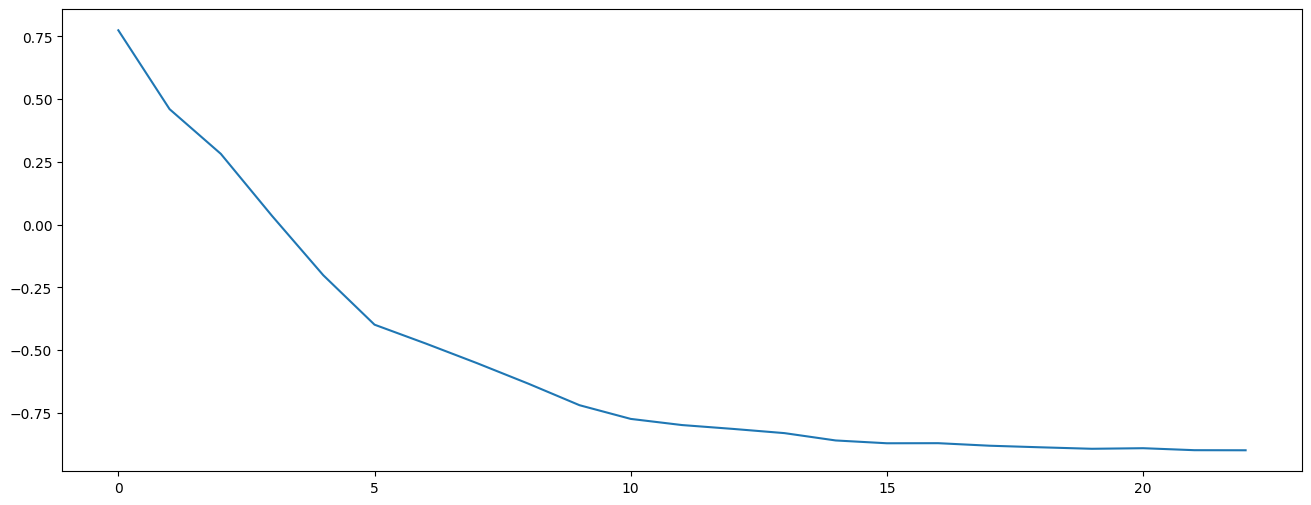

In [12]:
plt.figure(figsize=(16, 6))
# instead, average across 1_000 points
r = (len(lossi) // 100) * 100
plt.plot(torch.tensor(lossi)[:r].view(-1, 100).mean(1))


In [13]:
for sample in range(1):
    gen_ctx = torch.tensor([[[1, 0.0, 0.0, 0.0]] * (CONTEXT_LEN - 1) + [[2, 0.0, 0.0, 0.0]]], device='cuda')
    generated = model.generate(gen_ctx, max_new_tokens=1_000)
    with open(f"sample-{sample}.tokens", 'wb') as f:
        cbor2.dump(generated, f)
        print("wrote", f.name)

wrote sample-0.tokens


In [14]:
display(data[:20])

tensor([[2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7000e+01, 4.0000e+00, 0.0000e+00, 2.9134e-01],
        [4.9000e+01, 4.0000e+00, 0.0000e+00, 2.2835e-01],
        [5.6000e+01, 1.0417e-02, 0.0000e+00, 3.6220e-01],
        [6.1000e+01, 0.0000e+00, 3.3333e-01, 2.3622e-01],
        [6.4000e+01, 6.6667e-01, 3.3333e-01, 3.3858e-01],
        [5.6000e+01, 0.0000e+00, 3.3333e-01, 2.9921e-01],
        [6.1000e+01, 0.0000e+00, 3.3333e-01, 2.2835e-01],
        [6.4000e+01, 6.6667e-01, 3.3333e-01, 2.5197e-01],
        [5.6000e+01, 0.0000e+00, 3.3333e-01, 2.5197e-01],
        [6.1000e+01, 0.0000e+00, 3.3333e-01, 1.9685e-01],
        [6.4000e+01, 6.6667e-01, 3.3333e-01, 1.9685e-01],
        [5.6000e+01, 0.0000e+00, 3.3333e-01, 2.5984e-01],
        [6.1000e+01, 0.0000e+00, 3.3333e-01, 2.2835e-01],
        [6.4000e+01, 3.5417e-01, 3.3333e-01, 2.2835e-01],
        [3.5000e+01, 4.0000e+00, 3.3333e-01, 3.3071e-01],
        [4.7000e+01, 4.0000e+00, 0.0000e+00, 2.9921e-01],
        [5.600

In [ ]:
@torch.no_grad()
def split_loss(split):
    model.eval()
    data = {
        "train": train_data,
        "eval": eval_data,
    }[split]
    ix = torch.randint(len(data) - CONTEXT_LEN, (BATCH_SIZE,))
    x = torch.stack([data[i:i+CONTEXT_LEN] for i in ix]).cuda()
    y = torch.stack([data[i+1:i+CONTEXT_LEN+1] for i in ix]).cuda()
    logits, loss = model(x, y)
    print(split, loss.item())
    model.train()

split_loss("train")
split_loss("eval")

In [84]:
torch.save(model, "")

In [17]:
torch.cuda.empty_cache()